Implementation of Transfer Learning

In [49]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [60]:
dataset_path = '/content/drive/MyDrive/cvpr dataset/train'

In [61]:

import os
import cv2

# Assuming dataset_path and files_to_remove are defined elsewhere in your code
class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Found classes:", class_names)

all_image_paths = []
files_to_remove = {
}

# Loop through each class
for class_name in class_names:
    print(f"Processing class: {class_name}")

    class_dir = os.path.join(dataset_path, class_name)
    class_image_count = 0  # Counter to track the number of images added for this class

    for filename in os.listdir(class_dir):
        if class_image_count >= 5000:  # Stop if we already have 5,000 images for this class
            break

        file_path = os.path.normpath(os.path.join(class_dir, filename))
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            if file_path in files_to_remove:
                print(f"Excluding problematic image: {file_path}")
                continue

            all_image_paths.append(file_path)
            class_image_count += 1  # Increment the counter after adding an image

    print(f"Collected {class_image_count} images for class: {class_name}")

print(f"Total images found (excluding problematic ones): {len(all_image_paths)}")

valid_image_paths = []
for path in all_image_paths:
    img = cv2.imread(path)
    if img is None:
        print(f"Warning: Could not load image {path}")
    else:
        valid_image_paths.append(path)

print(f"Total valid images: {len(valid_image_paths)}")

Found classes: ['women', 'men']
Processing class: women
Collected 110 images for class: women
Processing class: men
Collected 110 images for class: men
Total images found (excluding problematic ones): 220
Total valid images: 220


In [62]:
train_paths, val_paths = train_test_split(valid_image_paths, test_size=0.20, random_state=42)
print(f"Training set size: {len(train_paths)} images")
print(f"Validation set size: {len(val_paths)} images")

Training set size: 176 images
Validation set size: 44 images


In [63]:
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Loads an image in grayscale, resizes it to target_size,
    and returns an array with shape (target_size[0], target_size[1], 1)
    """
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        return None
    img_resized = cv2.resize(img_gray, target_size)
    # Normalize pixel values to [0,1]
    img_normalized = img_resized.astype('float32') / 255.0
    # Add a channel dimension to get (224, 224, 1)
    return img_normalized.reshape(target_size[0], target_size[1], 1)

def get_label_from_path(img_path):
    """
    Extracts the label from the file path. Assumes the immediate parent folder name is the label.
    For example: '/.../mammals/tiger/00000019.jpg' -> 'tiger'
    """
    return os.path.basename(os.path.dirname(img_path))

In [65]:

sorted_class_names = sorted(class_names)
label_to_index = {label: idx for idx, label in enumerate(sorted_class_names)}
print("Label to index mapping:", label_to_index)

def load_dataset(image_paths):
    X = []  # images
    y = []  # labels
    for path in image_paths:
        img = preprocess_image(path)
        if img is None:
            continue
        label = get_label_from_path(path)
        if label not in label_to_index:
            continue
        X.append(img)
        y.append(label_to_index[label])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = load_dataset(train_paths)
X_val, y_val = load_dataset(val_paths)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

Label to index mapping: {'men': 0, 'women': 1}
X_train shape: (176, 224, 224, 1)
y_train shape: (176,)
X_val shape: (44, 224, 224, 1)
y_val shape: (44,)


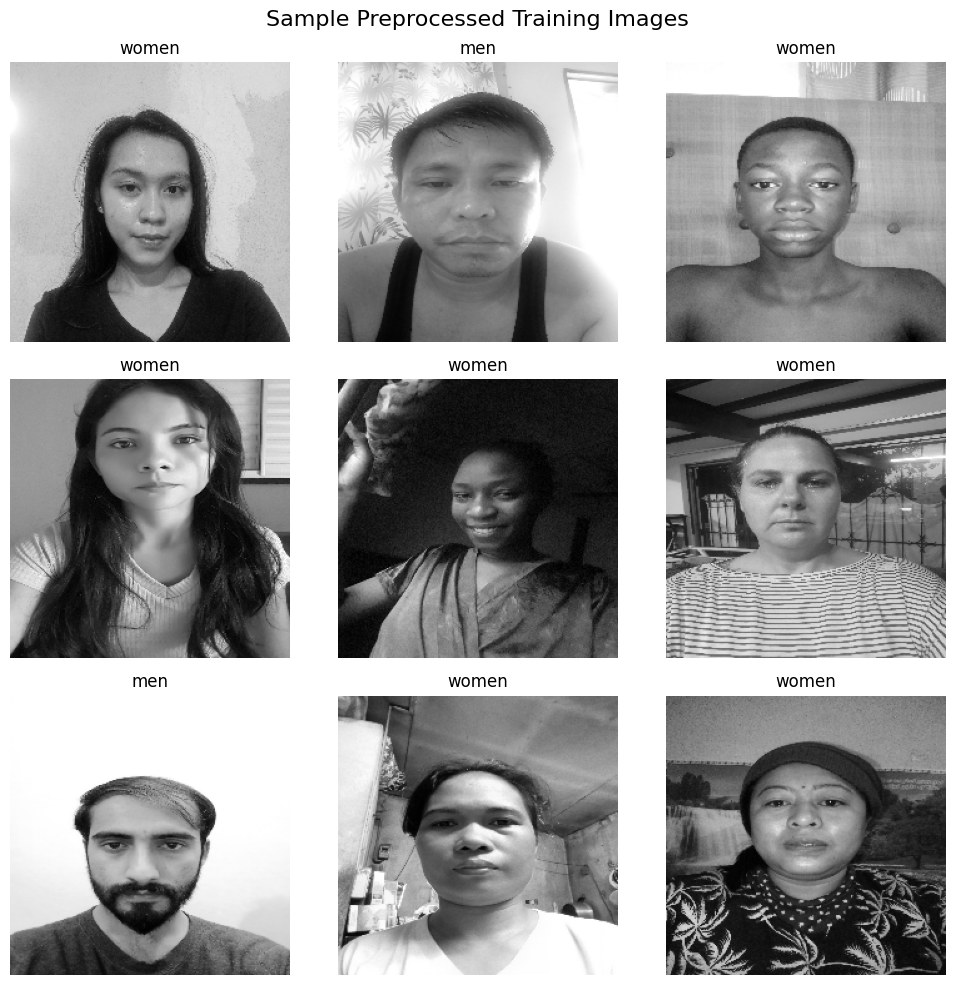

In [66]:
num_classes = len(sorted_class_names)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

plt.figure(figsize=(10, 10))
sample_indices = random.sample(range(len(X_train)), min(9, len(X_train)))
for idx, sample_idx in enumerate(sample_indices):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(X_train[sample_idx].squeeze(), cmap='gray')
    # Optionally, show the corresponding class name as title
    label_index = y_train[sample_idx]
    class_name = sorted_class_names[label_index]
    plt.title(class_name)
    plt.axis('off')
plt.suptitle("Sample Preprocessed Training Images", fontsize=16)
plt.tight_layout()
plt.show()

In [67]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import AdamW


# Load the pre-trained model
model = load_model("/content/drive/MyDrive/cvpr model/Final_Model (1).h5")

# Use the input of the first layer as the model's input
input_tensor = model.layers[0].input

# Freeze the base model layers (only train the new layers)
for layer in model.layers:
    layer.trainable = False

# Add two extra convolutional layers with regularization
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Global Average Pooling to reduce dimensionality
x = GlobalAveragePooling2D()(x)

# Fully connected layers with Dropout and L2 regularization
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

new_output = Dense(2, activation='softmax')(x)

# Build the final model
new_model = Model(inputs=input_tensor, outputs=new_output)

new_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model summary
print(new_model.summary())

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 120,738 (471.63 KB)

 Trainable params: 119,650 (467.38 KB)

 Non-trainable params: 1,088 (4.25 KB)

None


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.3822 - loss: 1.8282 - val_accuracy: 0.5000 - val_loss: 0.9821
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4552 - loss: 1.4542 - val_accuracy: 0.5000 - val_loss: 0.9864
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5424 - loss: 1.2492 - val_accuracy: 0.5000 - val_loss: 0.9952
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4923 - loss: 1.4235 - val_accuracy: 0.5000 - val_loss: 1.0035
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4401 - loss: 1.3806 - val_accuracy: 0.5000 - val_loss: 1.0106
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5155 - loss: 1.3647 - val_accuracy: 0.5000 - val_loss: 1.0200
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5836 - loss: 1.1334 - val_accuracy: 0.5000 - val_loss: 1.0270
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5738 - loss: 1.1875 - val_accuracy: 0.5000 -

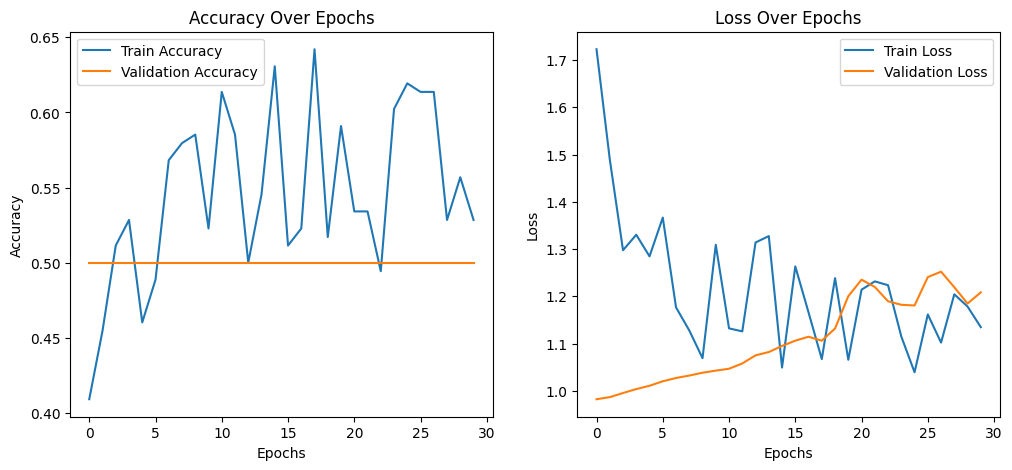

In [68]:
import matplotlib.pyplot as plt

# Train the model and store history
history = new_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    #callbacks=[early_stopping, reduce_lr],
    batch_size=16
)

# Plot Accuracy & Loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.show()
plot_history(history)


In [69]:
model.save("Transfer_final.h5")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step


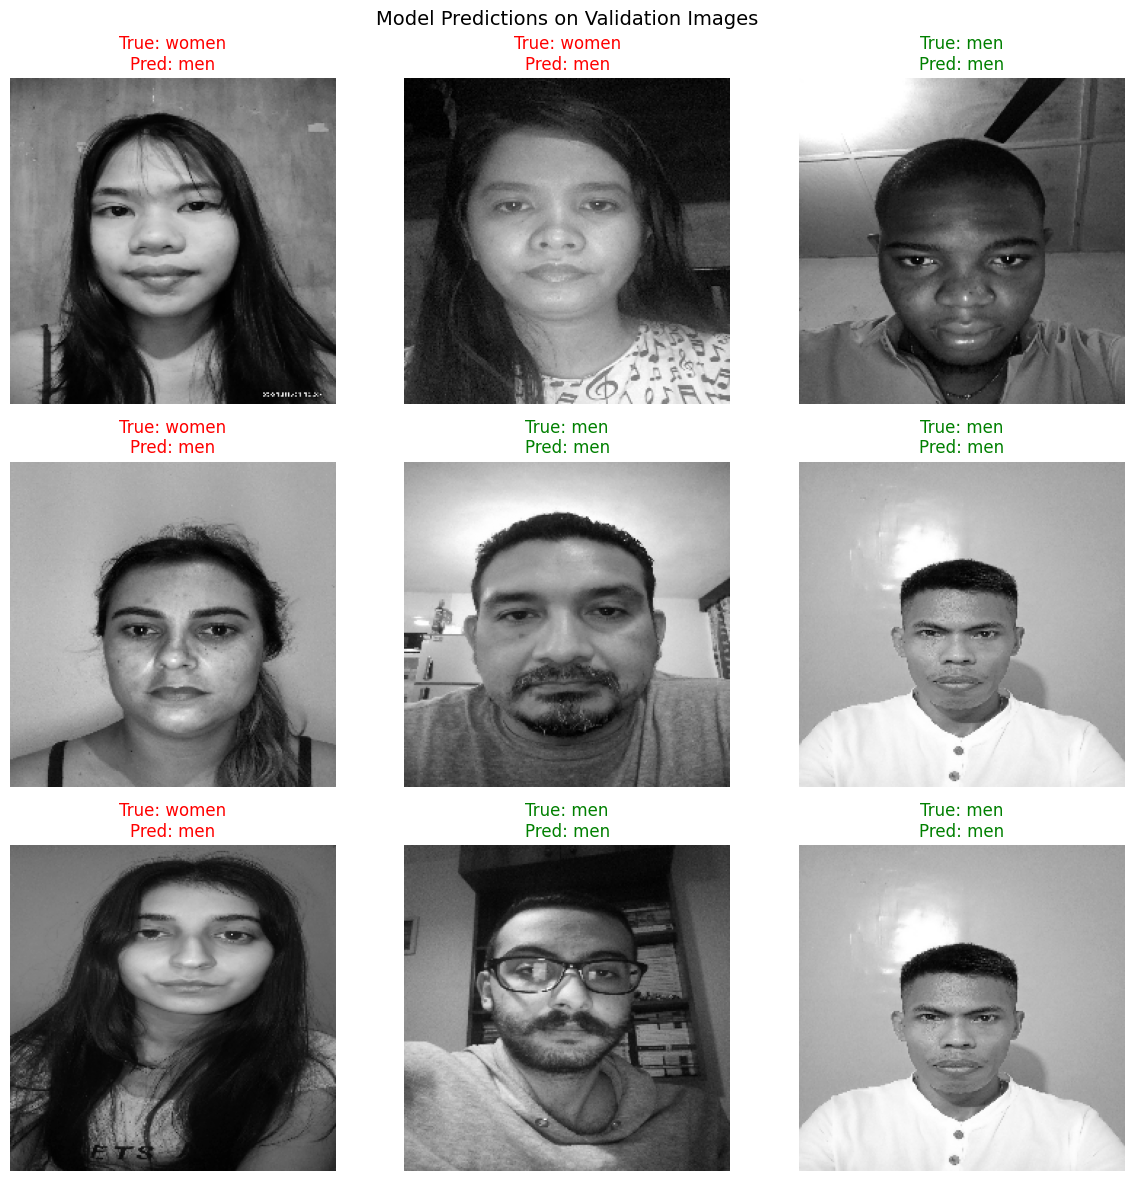

In [70]:
import numpy as np
import random
import matplotlib.pyplot as plt

def test_model(model, X_val, y_val, class_labels, num_images=9):
    """
    Tests the given model using a batch from the validation dataset.

    Parameters:
    - model: Trained TensorFlow model.
    - X_val: Validation images (numpy array).
    - y_val: Validation labels (one-hot encoded).
    - class_labels: List of class labels.
    - num_images: Number of images to display.
    """
    predictions = model.predict(X_val)

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        index = random.randint(0, len(X_val) - 1)
        img = X_val[index]
        true_label = np.argmax(y_val[index])
        predicted_label = np.argmax(predictions[index])

        plt.subplot(3, 3, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {class_labels[true_label]}\nPred: {class_labels[predicted_label]}",
                  color="green" if true_label == predicted_label else "red")
        plt.axis("off")

    plt.suptitle("Model Predictions on Validation Images", fontsize=14)
    plt.tight_layout()
    plt.show()

# Ensure correct class labels are used
class_labels = sorted_class_names

# Test the trained model
test_model(new_model, X_val, y_val_cat, class_labels)
